In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
# Load the saved training, validation, and testing data loaders from files
train_loader = torch.load("../data/train_loader.pt")
val_loader = torch.load("../data/val_loader.pt")
test_loader = torch.load("../data/test_loader.pt")

In [31]:
# Define a neural network architecture with convolutional and fully connected layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define convolutional layers with ReLU activation functions and max-pooling layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        # Define fully connected layers
        self.fc1 = nn.Linear(4 * 14 * 14, 32)
        self.act5 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # Define the forward pass of the network
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = self.pool4(self.act4(self.conv4(out)))
        out = out.view(-1, 4 * 14 * 14)
        out = self.act5(self.fc1(out))
        out = self.fc2(out)

        return out

In [32]:
# Initialize the PyTorch device to CUDA if available, otherwise defaults to CPU
device = torch.device("cuda" if torch.cuda.is_available() else torch.device("cpu"))

In [33]:
def training_loop(n_epochs, model, criterion, optimizer, train_loader, val_loader):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses (if val_loader is provided)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            loss_train += loss.item()  # Accumulate training loss

        avg_loss_train = loss_train / len(train_loader)  # Calculate average training loss
        train_losses.append(avg_loss_train)  # Append training loss to the list

        if val_loader is not None:  # If validation data is provided
            loss_val = 0.0
            with torch.no_grad():  # Disable gradient calculation for validation
                for val_images, val_labels in val_loader:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move validation data to device
                    val_outputs = model(val_images)  # Forward pass on validation data
                    loss_val += criterion(val_outputs, val_labels).item()  # Calculate validation loss
            avg_val_loss = loss_val / len(val_loader)  # Calculate average validation loss
            val_losses.append(avg_val_loss)  # Append validation loss to the list

        # Print training and validation losses for each epoch
        print('{} Epoch {}, Training loss: {:.4f}'.format(
            datetime.datetime.now(), epoch, avg_loss_train))
        if val_loader is not None:
            print('{} Epoch {}, Validation loss: {:.4f}'.format(
                datetime.datetime.now(), epoch, avg_val_loss))

    return train_losses, val_losses  # Return training and validation losses

In [34]:
# Plot the training and validation loss curves using Matplotlib
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

In [35]:
# Set up parameters for training:
n_epochs = 9
model = Net()
batch_size = 64
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [36]:
train_losses, val_losses = training_loop(n_epochs, model, criterion, optimizer, train_loader, val_loader)

2024-04-13 21:45:57.765496 Epoch 1, Training loss: 0.4828
2024-04-13 21:45:57.765638 Epoch 1, Validation loss: 0.3550
2024-04-13 21:48:37.254911 Epoch 2, Training loss: 0.3523
2024-04-13 21:48:37.255038 Epoch 2, Validation loss: 0.3157
2024-04-13 21:51:18.577864 Epoch 3, Training loss: 0.3284
2024-04-13 21:51:18.578001 Epoch 3, Validation loss: 0.3344
2024-04-13 21:53:58.444265 Epoch 4, Training loss: 0.3076
2024-04-13 21:53:58.444371 Epoch 4, Validation loss: 0.2886
2024-04-13 21:56:36.715133 Epoch 5, Training loss: 0.2989
2024-04-13 21:56:36.715271 Epoch 5, Validation loss: 0.3072
2024-04-13 21:59:16.316041 Epoch 6, Training loss: 0.2886
2024-04-13 21:59:16.316134 Epoch 6, Validation loss: 0.2848
2024-04-13 22:01:56.732416 Epoch 7, Training loss: 0.2803
2024-04-13 22:01:56.732512 Epoch 7, Validation loss: 0.4018
2024-04-13 22:04:38.960495 Epoch 8, Training loss: 0.2742
2024-04-13 22:04:38.960724 Epoch 8, Validation loss: 0.2788
2024-04-13 22:07:17.269728 Epoch 9, Training loss: 0.257

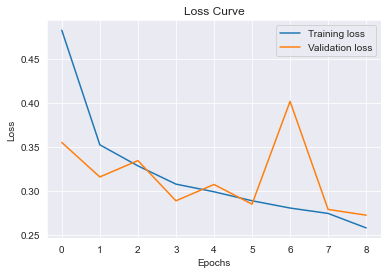

In [37]:
plot_losses(train_losses, val_losses)

In [38]:
# Evaluate the trained model on the validation set and print validation loss and accuracy
val_loss = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = val_outputs.max(1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

print('Validation loss: {:.4f}'.format(val_loss / len(val_loader)))
print('Validation accuracy: {:.2f}%'.format(100 * correct / total))

Validation loss: 0.2722
Validation accuracy: 88.01%


In [39]:
# Evaluate the trained model on the test set and print test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for t_images, t_labels in test_loader:
        t_images, t_labels = t_images.to(device), t_labels.to(device)
        t_outputs = model(t_images)
        test_loss += criterion(t_outputs, t_labels).item()
        _, predicted = t_outputs.max(1)
        total += t_labels.size(0)
        correct += (predicted == t_labels).sum().item()

print('Test loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test accuracy: {:.2f}%'.format(100 * correct / total))

Test loss: 0.2904
Test accuracy: 88.30%


In [40]:
# # Use the trained model to make predictions on the test set and extract predicted classes
model.eval()
predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predictions.extend(outputs.tolist())
        test_labels.extend(labels.tolist())

probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [41]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1100
           1       0.83      0.93      0.88       900

    accuracy                           0.88      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.89      0.88      0.88      2000



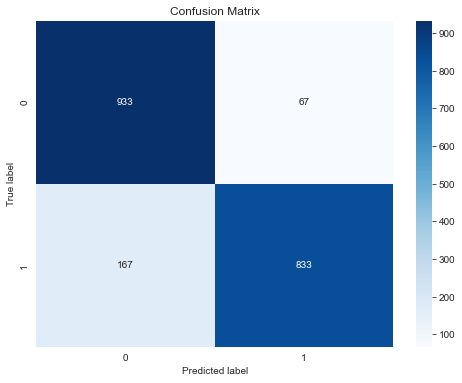

In [42]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()